In [161]:
import json
import re
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cohere
from cohere import ClassifyExample
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score,precision_score, recall_score

In [162]:
def extract_info(json_file):

    data_list = []
    # Charger le fichier JSON
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Parcourir chaque élément du JSON
    for img, info in data.items():
        # Diviser les informations en lignes en séparant par "\n"
        lines = info.split("\n")

        # Parcourir chaque ligne
        for line in lines:
            # Retirer les éléments vides résultant de la division
            elements = re.findall(r"[\S\s]*?(?=Ⓟ|Ⓞ|Ⓕ|Ⓜ|Ⓐ|Ⓒ|Ⓚ|Ⓑ|Ⓘ|Ⓗ|Ⓔ|$)", line)
            elements = [element.strip() for element in elements if element.strip()]
            target, nom, prenom, profession, lien, age, annee, nationalite, ville, biz = "", "", "", "", "", "", "", "", "", ""
            for element in elements:
                # Supprimer les logos de la colonne "nom"
                #element = element.replace('Ⓞ', '').replace('Ⓟ', '')  # Supprimer les logos Ⓞ et Ⓟ
                if 'Ⓟ' in element:
                    target=True
                    nom=element.replace('Ⓟ', '')
                elif 'Ⓞ' in element:
                    target=False
                    nom=element.replace('Ⓞ', '')
                elif 'Ⓕ' in element:
                    prenom=element.replace('Ⓕ', '')
                elif 'Ⓜ' in element:
                    profession=element.replace('Ⓜ', '')
                elif 'Ⓐ' in element:
                    age=element.replace('Ⓐ', '')
                elif 'Ⓚ' in element:
                    nationalite=element.replace('Ⓚ', '')
                elif 'Ⓑ' in element:
                    annee=element.replace('Ⓑ', '')
                elif 'Ⓘ' in element:
                    ville=element.replace('Ⓘ', '')
                elif 'Ⓗ' in element or 'Ⓒ' in element:
                    if 'Ⓛ' in element:
                        element=element.replace('Ⓗ', '').replace('Ⓒ', '')
                        lien=element.split('Ⓛ', 1)[0]
                    else:
                        lien=element.replace('Ⓗ', '').replace('Ⓒ', '') 
                elif 'Ⓔ' in element:
                    biz=element.replace('Ⓔ', '')

                    
            # Stocker les données dans un dictionnaire
            data_dict = {'Target': target, 'Nom': nom, 'Prenom': prenom, 'Profession': profession,
                            'Relation': lien, 'Age': age,'Année':annee, 'Nationalité': nationalite, 'Ville': ville, 'Plus':biz}
            # Ajouter le dictionnaire à la liste
            data_list.append(data_dict)

    return pd.DataFrame(data_list)

In [163]:
# Chemin vers le fichier JSON
json_file = "entities.json"

# Appeler la fonction pour extraire les informations et créer le dataset
df=extract_info(json_file)

df.head()

,Target,Nom,Prenom,Profession,Relation,Age,Année,Nationalité,Ville,Plus
0,False,Breton,Cyrille,menuisier,Garçon,25,,française,,
1,True,Ferazzi,Auguste,vitrier,Garçon,30,,Piémontaise,,
2,True,Machol,Pierre,vitrier,Garçon,24,,Piémontaise,,
3,True,Desbois,Alexandre,prop re,Homme marié,48,,française,,
4,False,Vignat,Zélie,prop re,sa fe,30,,française,,


In [164]:
# Enlever les lignes vides
df=df[(df['Prenom']!='') & ((df['Target']==True)|(df['Target']==False))]

In [165]:
# Enlever les lignes où il y a chef et l'etiquette est false
index_to_drop = df[(df['Target'] == False) & ((df['Relation'].str.startswith('ch')) | (df['Relation'].str.startswith('Ch')))].index
df = df.drop(index_to_drop)

In [166]:
def create_description_column(df):
    df['Description'] = ""
    for index, row in df.iterrows():
        if row['Prenom']!='':
            description = row['Prenom'] + " " + row['Nom'] + " " 
        if row['Age']!='':
            description += row['Age'] + " "
        if row['Nationalité']!='':
            description += row['Nationalité'] + " "
        if row['Profession']!='':
            description += row['Profession'] + " "
        if row['Relation']!='':
            description += row['Relation'] + " "
        if row['Ville']!='':
            description += row['Ville'] + " "
        df.at[index, 'Description'] = description

    return df

# Appel de la fonction pour créer la nouvelle colonne
df = create_description_column(df)

df.head()

,Target,Nom,Prenom,Profession,Relation,Age,Année,Nationalité,Ville,Plus,Description
0,False,Breton,Cyrille,menuisier,Garçon,25,,française,,,Cyrille Breton 25 française menuisier Garçon
1,True,Ferazzi,Auguste,vitrier,Garçon,30,,Piémontaise,,,Auguste Ferazzi 30 Piémontaise vitrier Garçon
2,True,Machol,Pierre,vitrier,Garçon,24,,Piémontaise,,,Pierre Machol 24 Piémontaise vitrier Garçon
3,True,Desbois,Alexandre,prop re,Homme marié,48,,française,,,Alexandre Desbois 48 française prop re Homme m...
4,False,Vignat,Zélie,prop re,sa fe,30,,française,,,Zélie Vignat 30 française prop re sa fe


In [167]:
# Formation des données
X=df['Description'].tolist()
y=df['Target'].tolist()

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [168]:
examples = []  # Liste pour stocker les inputs

# Garder que 2500 données d'entrainements
for text, label in zip(X_train, y_train):
    # Créer un nouvel exemple et l'ajouter à la liste examples
    examples.append(ClassifyExample(text=text, label=label))
    if len(examples)==2500:
        break

In [169]:
# recupérer les réponses pour chaque appel API
list_xtest=[]
global_list=[]
for x in X_test:
    if len(list_xtest)==90:
        global_list.append(list_xtest)
        list_xtest=[x]
    else:
       list_xtest.append(x)

if list_xtest:
    global_list.append(list_xtest)

In [175]:
# Appel API
predictions_list=[]
for lst in global_list:
    co = cohere.Client("q5SRgMDd5NDse1jEarBhnYCXf9fz0b5SKqGZNq3Y")
    response = co.classify(
        examples=examples,
        inputs=lst
    )
    predictions = [classification.prediction for classification in response.classifications]
    
    # Ajouter les prédictions à la liste des prédictions
    predictions_list.append(predictions)

In [176]:
# Liste principale
flattened_list = []

# Aplatir la liste de listes
for sublist in predictions_list:
    flattened_list.extend(sublist)

In [177]:
flattened_list= [True if s == 'True' else False for s in flattened_list]

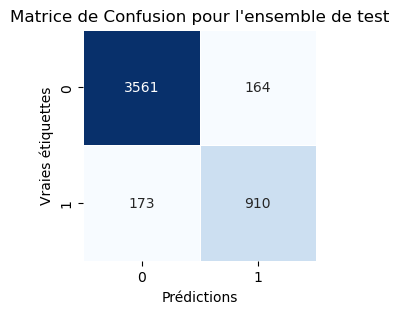

In [178]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, flattened_list)

# Utiliser Seaborn pour l'affichage
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar=False)
plt.title('Matrice de Confusion pour l\'ensemble de test')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

In [179]:
print("Métriques pour l'ensemble d'entraînement:")
print(classification_report(y_test, flattened_list))

Métriques pour l'ensemble d'entraînement:
              precision    recall  f1-score   support

       False       0.95      0.96      0.95      3725
        True       0.85      0.84      0.84      1083

    accuracy                           0.93      4808
   macro avg       0.90      0.90      0.90      4808
weighted avg       0.93      0.93      0.93      4808



In [180]:
print('f1-score: ',f1_score(flattened_list, y_test))
print('Precision: ',precision_score(flattened_list, y_test))
print('Recall: ',recall_score(flattened_list, y_test))

f1-score:  0.8437644877144181
Precision:  0.840258541089566
Recall:  0.8472998137802608


## Piste d'amélioration: Description contextuelle

In [181]:
# Chemin vers le fichier JSON
json_file = "entities.json"

# Appeler la fonction pour extraire les informations et créer le dataset
df=extract_info(json_file)

In [182]:
# Enlever les lignes vides
df=df[(df['Prenom']!='') & ((df['Target']==True)|(df['Target']==False))]

# Enlever les lignes où il y a chef et l'etiquette est false
index_to_drop = df[(df['Target'] == False) & ((df['Relation'].str.startswith('ch')) | (df['Relation'].str.startswith('Ch')))].index
df = df.drop(index_to_drop)

In [183]:
def create_description_column(df):
    df['Description'] = ""
    for index, row in df.iterrows():
        if row['Prenom']!='':
            description = "La personne s'appelle " + row['Prenom'] + " " + row['Nom'] + ","
        if row['Age']!='':
            description += " âgé de " + str(row['Age']) + " ans,"
        if row['Nationalité']!='':
            description += " de nationalité " + row['Nationalité'] + ","
        if row['Profession']!='':
            description += " exerçant la profession de " + row['Profession'] + ","
        if row['Relation']!='':
            description += " étant " + row['Relation'] + " du ménage,"
        if row['Ville']!='':
            description += " habitant à " + row['Ville'] + "."
        df.at[index, 'Description'] = description

    return df

# Appel de la fonction pour créer la nouvelle colonne
df = create_description_column(df)

In [184]:
df.head()

,Target,Nom,Prenom,Profession,Relation,Age,Année,Nationalité,Ville,Plus,Description
0,False,Breton,Cyrille,menuisier,Garçon,25,,française,,,"La personne s'appelle Cyrille Breton, âgé de 2..."
1,True,Ferazzi,Auguste,vitrier,Garçon,30,,Piémontaise,,,"La personne s'appelle Auguste Ferazzi, âgé de ..."
2,True,Machol,Pierre,vitrier,Garçon,24,,Piémontaise,,,"La personne s'appelle Pierre Machol, âgé de 24..."
3,True,Desbois,Alexandre,prop re,Homme marié,48,,française,,,"La personne s'appelle Alexandre Desbois, âgé d..."
4,False,Vignat,Zélie,prop re,sa fe,30,,française,,,"La personne s'appelle Zélie Vignat, âgé de 30 ..."


In [185]:
X=df['Description'].tolist()
y=df['Target'].tolist()

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [186]:
examples = []  # Liste pour stocker les inputs

# Garder que 2500 données d'entrainements
for text, label in zip(X_train, y_train):
    # Créer un nouvel exemple et l'ajouter à la liste examples
    examples.append(ClassifyExample(text=text, label=label))
    if len(examples)==2500:
        break

In [187]:
# recupérer les réponses pour chaque appel API
list_xtest=[]
global_list=[]
for x in X_test:
    if len(list_xtest)==90:
        global_list.append(list_xtest)
        list_xtest=[x]
    else:
       list_xtest.append(x)

if list_xtest:
    global_list.append(list_xtest)

In [189]:
# Appel API
predictions_list=[]
for lst in global_list:
    co = cohere.Client("q5SRgMDd5NDse1jEarBhnYCXf9fz0b5SKqGZNq3Y")
    response = co.classify(
        examples=examples,
        inputs=lst
    )
    predictions = [classification.prediction for classification in response.classifications]
    
    # Ajouter les prédictions à la liste des prédictions
    predictions_list.append(predictions)

In [190]:
# Liste principale
flattened_list = []

# Aplatir la liste de listes
for sublist in predictions_list:
    flattened_list.extend(sublist)

In [191]:
flattened_list= [True if s == 'True' else False for s in flattened_list]

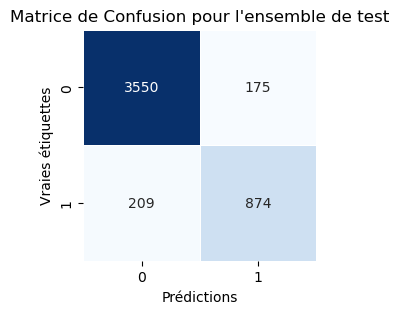

In [192]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, flattened_list)

# Utiliser Seaborn pour l'affichage
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar=False)
plt.title('Matrice de Confusion pour l\'ensemble de test')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

In [193]:
print("Métriques pour l'ensemble d'entraînement:")
print(classification_report(y_test, flattened_list))

Métriques pour l'ensemble d'entraînement:
              precision    recall  f1-score   support

       False       0.94      0.95      0.95      3725
        True       0.83      0.81      0.82      1083

    accuracy                           0.92      4808
   macro avg       0.89      0.88      0.88      4808
weighted avg       0.92      0.92      0.92      4808



In [194]:
print('f1-score: ',f1_score(flattened_list, y_test))
print('Precision: ',precision_score(flattened_list, y_test))
print('Recall: ',recall_score(flattened_list, y_test))

f1-score:  0.8198874296435272
Precision:  0.8070175438596491
Recall:  0.8331744518589133
